In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import random

# Load Data

In [2]:
# TODO: Load data here.
indexes = pd.read_csv('hw3_Data1/index.txt', delimiter = '\t', header = None)
x = pd.read_csv('hw3_Data1/gene.txt', delimiter = ' ', header = None).to_numpy().T
y = pd.read_csv('hw3_Data1/label.txt', header = None).to_numpy()
y = (y>0).astype(int).reshape(y.shape[0])

# Feature ranking: Subset-Based Feature Selection 

# Use PSO (particle swarm optimization)

# use f(x) = a * (1 - P) + (1-a)* #_select/#_features

x is 2000-D vector with all elements between 0-1

If x[i] >0.5, then index = i feature is chosen, else the feature is discarded

# Hyperparameter

In [20]:
a = 0.9 #重視正確率(a大)或重視選少feature, a = 0~1
gamma = 1
w = 0.5 #0.1~10 調自己的速度貢獻
phi_p = 1.2 #0.1~10 調自己最佳貢獻
phi_g = 1.2 #0.1~10 調global最佳貢獻
lr = 0.8 #0.1~10 縮放最終速度
iteration = 10 #跑幾輪
S = 100 #number of particles
k = 1 #Vmax[j] = k*((max(x[j])-min(x[j]))/2) , k = 0~1
w_decay = False

# define cost function

In [4]:
def cost_function(x,y,pi):
    idx = []
    for i in range(2000):
        if pi[i] > 0.5:
            idx.append(i)
    x_subset = x[:,idx]
    clf = DecisionTreeClassifier(random_state=0)
    scores = cross_val_score(clf, x_subset, y, cv=5)
    P = scores.mean()
    fx = a*(1 - P) + (1-a)*gamma*(len(idx))/(2000)
    return fx,P

# Initialization

In [21]:
ParticlePosition = np.random.uniform(low=0, high=1, size=(S,2000)) #Since there are 2000 features
ParticleBestPosition = ParticlePosition
ParticleBestCost = np.zeros((S,1))
ParticleVelocity = np.random.uniform(low=-1, high=1, size=(S,2000))
Vmax = k*0.5 #Vmax = k*(b_up-b_low)/2
g_cost = 65535 #global best value(least cost)
for i in range(S):
    cost,P = cost_function(x,y,ParticlePosition[i]) #smaller is better
    ParticleBestCost[i] = cost
    if cost < g_cost:
        g_cost = cost
        g = ParticlePosition[i]
        best_P = P

# main algorithm

In [22]:
# TODO: Design your score function for feature selection
P_record = []
for k in range(iteration):
    # w is linearly decay
#     print(k)
    if w_decay:
        wk = w - (w-0)*(k/iteration)
    else:
        wk = w
    for i in range(S): #for i-th particle
        for d in range(2000): #for each dimension
            rp = random.random()
            rg = random.random()
            ParticleVelocity[i][d] = wk*ParticleVelocity[i][d] +\
                                     phi_p*rp*(ParticleBestPosition[i][d] - ParticlePosition[i][d]) +\
                                     phi_g*rg*(g[d] - ParticlePosition[i][d])
            #keep the particle in space
            if ParticleVelocity[i][d] < -Vmax:
                ParticleVelocity[i][d] = -Vmax
            if ParticleVelocity[i][d] > Vmax:
                ParticleVelocity[i][d] = Vmax
            
            ParticlePosition[i][d] = ParticlePosition[i][d] + lr*ParticleVelocity[i][d]
            #keep the particle in space
            if ParticlePosition[i][d] < -1:
                ParticlePosition[i][d] = -1
            if ParticlePosition[i][d] > 1:
                ParticlePosition[i][d] = 1
            
        cost,P = cost_function(x,y,ParticlePosition[i])
        if cost < ParticleBestCost[i]:
            ParticleBestPosition[i] = ParticlePosition[i]
            ParticleBestCost[i] = cost
            if cost < g_cost:
                g = ParticlePosition[i]
                g_cost = cost
                best_P = P
    print("round",k,":",best_P)
    P_record.append(best_P)
# TODO: To use the provided evaluation sample code, you need to generate ranking_idx, which is the sorted index of feature

round 0 : 0.8525641025641025
round 1 : 0.8846153846153847
round 2 : 0.8846153846153847
round 3 : 0.8846153846153847
round 4 : 0.9012820512820513
round 5 : 0.9012820512820513
round 6 : 0.9012820512820513
round 7 : 0.9012820512820513
round 8 : 0.9012820512820513
round 9 : 0.9012820512820513


In [16]:
# print(g)

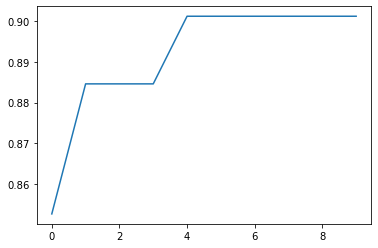

In [23]:
# print(P_record)
plt.plot(range(0, iteration, 1),P_record)

In [24]:
pickingidx = []
for i in range(2000):
    if g[i]>0.5:
        pickingidx.append(i)

In [25]:
print(best_P,'/',len(pickingidx))

0.9012820512820513 / 1015


# baseline: 0.9038461538461539 / 67

# Experiment Record

a = 1
w = 0.2
phi_p = 0.4
phi_g = 0.4
lr = 0.05
iteration = 40
S = 100

-> 0.9012820512820513 / 991

a = 0.7
w = 0.2
phi_p = 0.4
phi_g = 0.4
lr = 0.05
iteration = 40
S = 100

-> 0.8846153846153847 / 961

a = 0.3
w = 0.2
phi_p = 0.4
phi_g = 0.4
lr = 0.05
iteration = 40

#number of particles
S = 100

->0.8538461538461538/931

# Feature evaluation

In [ ]:
# Use a simple dicision tree with 5-fold validation to evaluate the feature selection result.
# You can try other classifier and hyperparameter.
score_history = []
for m in range(5, 2001, 5):
    # Select Top m feature
    x_subset = x[:, ranking_idx[:m]]

    # Build random forest
    clf = DecisionTreeClassifier(random_state=0)
    # clf = SVC(kernel='rbf', random_state=0) #build SVM

    # Calculate validation score
    scores = cross_val_score(clf, x_subset, y, cv=5)

    # Save the score calculated with m feature
    score_history.append(scores.mean())

# Report best accuracy.
print(f"Max of Decision Tree: {max(score_history)}")
print(f"Number of features: {np.argmax(score_history)*5+5}")

# Visualization

In [ ]:
plt.plot(range(5, 2001, 5), score_history, c='blue')
plt.title('Original')
plt.xlabel('Number of features')
plt.ylabel('Cross-validation score')
plt.legend(['Decision Tree'])
plt.savefig('1-3_result.png')

In [ ]:
idx = [3,6,7]
x[:,idx].shape

In [ ]:
pi =np.random.uniform(low=0, high=1, size=(2,2000))
cost_function(x,y,pi[0])

In [ ]:
pi =np.random.uniform(low=0, high=1, size=(2,2000))
pi[0]

In [ ]:
pi[1]

In [ ]:
pi[2]

In [ ]:
random.random()

In [ ]:
ParticlePosition = np.random.uniform(low=0, high=1, size=(S,2000)) #Since there are 2000 features
ParticleBestPosition = ParticlePosition
ParticleBestCost = np.zeros((S,1))
ParticleVelocity = np.random.uniform(low=-1, high=1, size=(S,2000))
g_cost = 65535 #global best value(least cost)
for i in range(S):
    cost,P = cost_function(x,y,ParticlePosition[i]) #smaller is better
    ParticleBestCost[i] = cost
    if cost < g_cost:
        g_cost = cost
        g = ParticlePosition[i]
        best_P = P

In [ ]:
print(ParticlePosition.shape)

In [ ]:
random.random()

In [ ]:

a = [0.8217948717948719, 0.8217948717948719, 0.85, 0.8538461538461538, 0.8538461538461538, 0.8538461538461538, 0.8538461538461538, 0.8538461538461538]
print(max(a),'/',a[2])

In [ ]:
plt.plot(range(0, k, 1),P_record)